In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
# import holoviews as hv
# import bokeh
# hv.extension('bokeh')
import pickle as pkl
from scipy.stats import norm
import numpy as np

import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

In [2]:
NSamp=10000
device = torch.device('cuda:0')
x = torch.linspace(0.,1.,NSamp).numpy()
train_x = torch.tensor(x).float().to(device=device)

In [11]:
with open(f"{home}vine.pkl","rb") as f:
    [covariances,y0,_] = pkl.load(f)
y = norm.cdf(y0)
assert x.shape[0]==y.shape[0]
x.reshape(NSamp,1).shape

(10000, 1)

In [29]:
H=1000
n_epoch = 3000
data_size = NSamp

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(y.shape[-1], H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2    

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
plot_loss = []
for epoch in range(n_epoch):
    x_sample=x.reshape(NSamp,1)
    y_sample=y
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor).to(device), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor).to(device), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor).to(device), requires_grad = True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret  # maximize
    plot_loss.append(-loss.data.cpu().numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

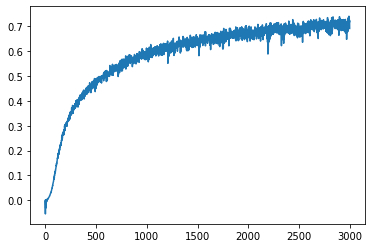

In [30]:
import matplotlib.pyplot as plt
plt.plot(plot_loss)

In [31]:
np.mean(plot_loss[-10:]/np.log(2))

1.0391445